In [234]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder

import warnings
warnings.filterwarnings(action = "ignore")

### Load dataset and perform cleaning/EDA

In [166]:
#Load data set
df = pd.read_csv("Dataset/data_clean")
df.head()

,LoanStatus,TotalProsperLoans,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPrincipalBorrowed,ProsperPaymentsOneMonthPlusLate,BorrowerAPR,ListingCategory (numeric),BorrowerState,EmploymentStatus,...,StatedMonthlyIncome,IncomeVerifiable,LoanOriginalAmount,MonthlyLoanPayment,ScorexChangeAtTimeOfListing,Term,ListingCreationDate,ProsperRating,Listing_Year,RevolveRatio
0,Completed,0,-1,-1,0.0,-1,0.16516,0,CO,Self-employed,...,3083.333333,True,9425,330.43,NaN,36,2007-08-26,C,2007,0.007784
1,Current,0,-1,-1,0.0,-1,0.12016,2,CO,Employed,...,6125.000000,True,10000,318.93,NaN,36,2014-02-27,A,2014,0.063510
2,Completed,0,-1,-1,0.0,-1,0.28269,0,GA,Not available,...,2083.333333,True,3001,123.32,NaN,36,2007-01-05,HR,2007,0.000000
3,Current,0,-1,-1,0.0,-1,0.12528,16,GA,Employed,...,2875.000000,True,10000,321.45,NaN,36,2012-10-22,A,2012,0.040000
4,Current,1,11,0,11000.0,0,0.24614,2,MN,Employed,...,9583.333333,True,15000,563.97,NaN,36,2013-09-14,D,2013,0.022957


In [167]:
#Check information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113932 entries, 0 to 113931
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   LoanStatus                           113932 non-null  object 
 1   TotalProsperLoans                    113932 non-null  int64  
 2   OnTimeProsperPayments                113932 non-null  int64  
 3   ProsperPaymentsLessThanOneMonthLate  113932 non-null  int64  
 4   ProsperPrincipalBorrowed             113932 non-null  float64
 5   ProsperPaymentsOneMonthPlusLate      113932 non-null  int64  
 6   BorrowerAPR                          113932 non-null  float64
 7   ListingCategory (numeric)            113932 non-null  int64  
 8   BorrowerState                        108420 non-null  object 
 9   EmploymentStatus                     113932 non-null  object 
 10  CurrentlyInGroup                     113932 non-null  bool   
 11  FirstRecorded

In [168]:
#Drop the column borrower state

df.drop(columns = "BorrowerState", inplace = True)

In [169]:
#Drop the column PublicRecordsLast12Months

df.drop(columns = "PublicRecordsLast12Months", inplace = True)

In [170]:
#Drop the column ScorexChangeAtTimeOfListing

df.drop(columns = "ScorexChangeAtTimeOfListing", inplace = True)

In [171]:
#Drop rows tha do not have entries of First RecordedLine

df = df[~df["FirstRecordedCreditLine"].isnull()]

In [172]:
#Feature engineer the column FirstRecordedCreditLine to firstrecordedcredityear

df["firstrecordedcredityear"] = pd.to_datetime(df["FirstRecordedCreditLine"]).dt.year

In [173]:
#Drop FirstRecordedCreditLine 

df.drop(columns = "FirstRecordedCreditLine", inplace=True)

In [174]:
#Drop na

df.dropna(inplace=True)

In [175]:
df.isnull().sum().sum()

0

<AxesSubplot:>

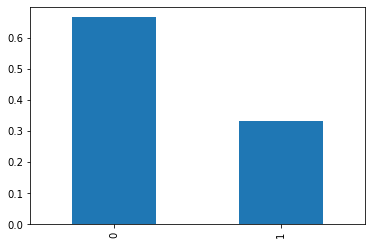

In [176]:
#Class balance
data["defaulted"].value_counts(normalize = True).plot(kind = "bar")

In [208]:
#Replace revolve ratio infinity values with 50,000 (A value not as high the previous values in dataset)
df["RevolveRatio"].sort_values(ascending=False)[1267:1290]

15739              inf
25457              inf
69954              inf
83949              inf
72461              inf
57893              inf
39687              inf
105702             inf
35151              inf
66819              inf
28721     4.682419e+04
109119    3.855615e+04
8461      3.806415e+04
226       3.439214e+04
82318     3.319213e+04
103546    2.754011e+04
103606    2.640011e+04
67695     2.636411e+04
109041    2.618410e+04
60563     2.600410e+04
55168     2.583610e+04
81982     2.328009e+04
19884     2.149209e+04
Name: RevolveRatio, dtype: float64

In [210]:
#Replace
df["RevolveRatio"] = df["RevolveRatio"].replace(np.inf, 50_000)

In [211]:
#Check new values
df["RevolveRatio"].sort_values(ascending=False)[1267:1290]

15739     50000.000000
25457     50000.000000
69954     50000.000000
83949     50000.000000
72461     50000.000000
57893     50000.000000
39687     50000.000000
105702    50000.000000
35151     50000.000000
66819     50000.000000
28721     46824.187297
109119    38556.154225
8461      38064.152257
226       34392.137569
82318     33192.132769
103546    27540.110160
103606    26400.105600
67695     26364.105456
109041    26184.104736
60563     26004.104016
55168     25836.103344
81982     23280.093120
19884     21492.085968
Name: RevolveRatio, dtype: float64

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112577 entries, 0 to 113931
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   LoanStatus                           112577 non-null  object 
 1   TotalProsperLoans                    112577 non-null  int64  
 2   OnTimeProsperPayments                112577 non-null  int64  
 3   ProsperPaymentsLessThanOneMonthLate  112577 non-null  int64  
 4   ProsperPrincipalBorrowed             112577 non-null  float64
 5   ProsperPaymentsOneMonthPlusLate      112577 non-null  int64  
 6   BorrowerAPR                          112577 non-null  float64
 7   ListingCategory (numeric)            112577 non-null  int64  
 8   EmploymentStatus                     112577 non-null  object 
 9   CurrentlyInGroup                     112577 non-null  bool   
 10  OpenCreditLines                      112577 non-null  int64  
 11  OpenRevolving

### Split the dataset
- What we want to do is to split our dataset and use that algorithm to predict foe those still currently paying whether they will default or not.

In [220]:
#DRop those who are currently paying

data = df[df["LoanStatus"] != "Current"]

In [221]:
#Create column defaulted, where 1 represents yes and 0 represents 0 and completed

#Create function for that

def is_defaulted(x):
    if x == "Completed":
        return 0
    else:
        return 1

In [222]:
data["defaulted"] = data["LoanStatus"].apply(is_defaulted)

In [223]:
#Drop LoanStatus columns

data.drop(columns = "LoanStatus", inplace = True)

In [224]:
#Split dataset into training and testing

target = "defaulted"
X = data.drop(columns = target)
y = data[target]

In [225]:
#Split into train and test dataset

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.2
)

### Set baseline for model

In [236]:
y_train.value_counts(normalize = True).max()

0.6668906810035843

### Begin Model Iteration

In [226]:
#Initiate model

clf = make_pipeline(OrdinalEncoder(),
                    GradientBoostingClassifier())

In [227]:
#Initiate paremeter

param = {
    "gradientboostingclassifier__n_estimators": range(50, 401, 50),
    "gradientboostingclassifier__subsample": np.arange(0.3, 1.0, 0.3),
    "gradientboostingclassifier__max_depth": [3, 5, 7],
    "gradientboostingclassifier__max_features": ["sqrt", "log2"]
}
param

{'gradientboostingclassifier__n_estimators': range(50, 401, 50),
 'gradientboostingclassifier__subsample': array([0.3, 0.6, 0.9]),
 'gradientboostingclassifier__max_depth': [3, 5, 7],
 'gradientboostingclassifier__max_features': ['sqrt', 'log2']}

In [228]:
#Use paramater is RandomizedSearch

model = RandomizedSearchCV(clf, 
                   param_distributions=param,
                   cv = 5, n_jobs=-1,
                   n_iter=200, verbose=1,
                   random_state=42
                  )

In [229]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__max_depth': [3,
                                                                                  5,
                                                                                  7],
                                        'gradientboostingclassifier__max_features': ['sqrt',
                                                                                     'log2'],
                                        'gradientboostingclassifier__n_estimators': range(50, 401, 50),
                                        'gradientboostingclassifier__subsample': array([0.3, 0.6, 0.9]

In [232]:
print(f"The model best score is given as {round(model.best_score_, 2)} and the ")

The model best score is given as 0.72


With a baseline score of 0.66,we beat the baseline by a marging of 0.06. We might conisder oversampling our minority class in the dataset to improve the signal and possibly the model score.

In [233]:
model.best_params_

{'gradientboostingclassifier__subsample': 0.8999999999999999,
 'gradientboostingclassifier__n_estimators': 350,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__max_depth': 3}

From the above, we see the best parameters as given above

In [260]:
#Increase model precision

model_predictions = (model.predict_proba(X_train)[:, 1] > 0.7).astype(int)

In [255]:
#model_predictions = model.predict(X_train)

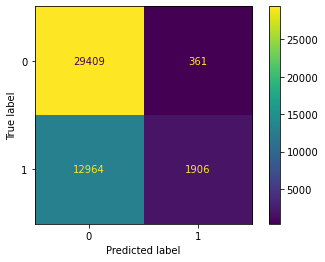

In [261]:
ConfusionMatrixDisplay.from_predictions(y_train, model_predictions);

In [262]:
print(classification_report(y_train, model_predictions))

              precision    recall  f1-score   support

           0       0.69      0.99      0.82     29770
           1       0.84      0.13      0.22     14870

    accuracy                           0.70     44640
   macro avg       0.77      0.56      0.52     44640
weighted avg       0.74      0.70      0.62     44640



From this we have a model that predicts that a person is going to default a loan by a precision of **84%**. Going further to use this model on a test set.

### Evaluating Model on Test set

In [263]:
test_model_predictions = (model.predict_proba(X_test)[:, 1] > 0.7).astype(int)

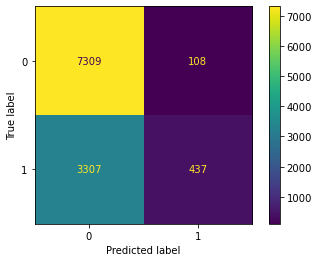

In [264]:
ConfusionMatrixDisplay.from_predictions(y_test, test_model_predictions);

In [265]:
print(classification_report(y_test, test_model_predictions))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      7417
           1       0.80      0.12      0.20      3744

    accuracy                           0.69     11161
   macro avg       0.75      0.55      0.51     11161
weighted avg       0.73      0.69      0.61     11161



The model shows low variance in the results obtained, a good model for consideration that can generalize well. Now let us apply it to a real world scenarios of current loan payers

### Evaluating Model on Real life data set

In [268]:
rl = df[df["LoanStatus"] == "Current"].drop(columns = "LoanStatus")

In [269]:
rl_pred = (model.predict_proba(rl)[:, 1] > 0.7).astype(int)
rl_pred

array([0, 0, 0, ..., 0, 0, 0])

In [273]:
print(f"The model predicts that {rl_pred.sum()} people will default on their loan with a precicion of about 80%")

The model predicts that 513 people will default on their loan with a precicion of about 80%


The model still does not perform very well with catching only 513 people at 80% precision. But it could serve as a good baseline model...

- In other to find more good use of the model, a datframe for the prediction could be made and each id could be the index of such table. This information could then be used by the custom care to take actions of loans that are currently being paid